### Import libraries and create DataFrame from csv 

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Prompt user for week selection
start_week = int(input("Enter the start week for analysis: "))
end_week = int(input("Enter the end week for analysis (enter the same as start week for single week analysis): "))
weeks = str(start_week) if start_week == end_week else f"{start_week} - {end_week}"

# Function to read, preprocess, group by player, and aggregate data for the selected weeks
def read_data(start_week, end_week):
    data = pd.DataFrame()

    for week in range(start_week, end_week + 1):
        temp_df = pd.read_excel("WR_Data.xlsx", sheet_name=f"Week{week}")

        # Preprocess: Drop irrelevant columns and convert data types
        temp_df.drop(['FL', 'ROST'], axis=1, inplace=True)
        convert = temp_df.select_dtypes('object').columns.difference(['Player'])
        temp_df[convert] = temp_df[convert].apply(lambda x: pd.to_numeric(x.str.replace(',', ''), errors='coerce')).fillna(0)
        temp_df['Rank'] = temp_df['Rank'].astype('Int64')

        # Group by 'Player' and aggregate data
        if data.empty:
            data = temp_df
        else:
            data = data.merge(temp_df, on='Player', suffixes=('', '_week' + str(week)))

    # Apply custom aggregation logic
    for column in data.columns:
        if column.endswith(tuple([f'_week{week}' for week in range(start_week + 1, end_week + 1)])):
            base_column = column.split('_week')[0]
            if base_column in ['Rank', 'Player']:  # Take the latest value
                data[base_column] = data[column]
            elif base_column in ['LG']:  # Take the maximum value
                data[base_column] = data[[base_column, column]].max(axis=1)
            else:  # Sum the values
                data[base_column] += data[column]
            data.drop(column, axis=1, inplace=True)  # Drop the extra week column

    # Calculate 'Y/A' and 'Y/R' based on summed values
    data['Y/R'] = (data['YDS'] / data['REC']).round(1)
    data['FPTS/G'] = (data['FPTS'] / data['G']).round(1)

    return data

# Load and aggregate data for the selected weeks
df = read_data(start_week, end_week)

# Recalculate 'Rank' based on 'FPTS' in descending order
df['Rank'] = df['FPTS'].rank(ascending=False, method='min').astype('int')

# Create 'Weeks' column
if start_week == end_week:
    df['Weeks'] = str(start_week)
else:
    df['Weeks'] = f"{start_week} - {end_week}"

df = df.sort_values(by='Rank')
df.head(10)

,Rank,Player,REC,TGT,YDS,Y/R,LG,20+,TD,ATT,YDS.1,TD.1,G,FPTS,FPTS/G,Weeks
10,1,Keenan Allen (LAC),43,55,474,11.0,38,8,3,0,0,0,4,106.4,26.6,9 - 12
1,2,CeeDee Lamb (DAL),32,48,433,13.5,30,10,3,3,21,1,4,101.4,25.3,9 - 12
0,3,Tank Dell (HOU),25,43,369,14.8,40,7,5,4,27,0,4,94.6,23.7,9 - 12
20,4,Mike Evans (TB),21,36,343,16.3,53,11,4,0,0,0,4,79.3,19.8,9 - 12
132,5,Amon-Ra St. Brown (DET),25,31,328,13.1,46,8,2,2,9,0,3,70.7,23.6,9 - 12
21,6,Tyreek Hill (MIA),27,33,310,11.5,38,8,2,2,5,0,3,68.5,22.8,9 - 12
46,7,Jayden Reed (GB),16,22,183,11.4,46,5,2,6,83,1,4,60.6,15.2,9 - 12
95,8,Brandin Cooks (DAL),17,21,294,17.3,37,11,2,0,0,0,4,58.4,14.6,9 - 12
296,9,Calvin Ridley (JAC),14,18,212,15.1,45,7,3,1,18,0,3,57.0,19.0,9 - 12
9,10,Chris Olave (NO),19,26,254,13.4,51,7,2,0,0,0,3,56.4,18.8,9 - 12


### Convert relevant stats to a per-game basis and create the final stats for analysis

In [32]:
# Define columns for per-game calculation
per_game = list(df.columns[2:])

# Define columns to exclude from the per-game calculation
exclude_per_game = ['Y/R', 'LG', 'G', 'FPTS', 'FPTS/G', 'Weeks']

# Create columns and convert stats to a per-game basis for the defined columns, not those in the exclude list
for col in per_game:
    if col not in exclude_per_game:
        df[col + '/game'] = (df[col] / df['G']).round(1)

# Define final columns to be used for analysis, combines excluded and new per-game columns
final_columns = exclude_per_game + [col + '/game' for col in per_game if col not in exclude_per_game]

# Display final columns with 'Rank' and 'Player'
df[['Rank', 'Player'] + final_columns].head(10)

,Rank,Player,Y/R,LG,G,FPTS,FPTS/G,Weeks,REC/game,TGT/game,YDS/game,20+/game,TD/game,ATT/game,YDS.1/game,TD.1/game
10,1,Keenan Allen (LAC),11.0,38,4,106.4,26.6,9 - 12,10.8,13.8,118.5,2.0,0.8,0.0,0.0,0.0
1,2,CeeDee Lamb (DAL),13.5,30,4,101.4,25.3,9 - 12,8.0,12.0,108.2,2.5,0.8,0.8,5.2,0.2
0,3,Tank Dell (HOU),14.8,40,4,94.6,23.7,9 - 12,6.2,10.8,92.2,1.8,1.2,1.0,6.8,0.0
20,4,Mike Evans (TB),16.3,53,4,79.3,19.8,9 - 12,5.2,9.0,85.8,2.8,1.0,0.0,0.0,0.0
132,5,Amon-Ra St. Brown (DET),13.1,46,3,70.7,23.6,9 - 12,8.3,10.3,109.3,2.7,0.7,0.7,3.0,0.0
21,6,Tyreek Hill (MIA),11.5,38,3,68.5,22.8,9 - 12,9.0,11.0,103.3,2.7,0.7,0.7,1.7,0.0
46,7,Jayden Reed (GB),11.4,46,4,60.6,15.2,9 - 12,4.0,5.5,45.8,1.2,0.5,1.5,20.8,0.2
95,8,Brandin Cooks (DAL),17.3,37,4,58.4,14.6,9 - 12,4.2,5.2,73.5,2.8,0.5,0.0,0.0,0.0
296,9,Calvin Ridley (JAC),15.1,45,3,57.0,19.0,9 - 12,4.7,6.0,70.7,2.3,1.0,0.3,6.0,0.0
9,10,Chris Olave (NO),13.4,51,3,56.4,18.8,9 - 12,6.3,8.7,84.7,2.3,0.7,0.0,0.0,0.0


### Calculate the correlations for the final stats across different conditions

In [33]:
# Define columns and columns to exclude for correlation calculation, from final columns
exclude_corr = ['FPTS/G', 'FPTS', 'G', 'Weeks']
corr_columns = [col for col in final_columns if col not in exclude_corr]

# Define a function to calculate correlations
def compute_correlations(dataframe, corr_columns):
    return dataframe[corr_columns].corrwith(dataframe['FPTS/G'])

# Compute correlations for various conditions
corr_all = compute_correlations(df, corr_columns)
corr_nonzero = compute_correlations(df[df['FPTS/G'] > 0], corr_columns)
corr_top50 = compute_correlations(df[df['Rank'] <= 50], corr_columns)
corr_top25 = compute_correlations(df[df['Rank'] <= 25], corr_columns)

# Compile all correlations into a DataFrame for comparison
df_corr = pd.DataFrame({
    'All Players': corr_all,
    'FPTS > 0': corr_nonzero,
    'Top 50 Players': corr_top50,
    'Top 25 Players': corr_top25
})

# Calculate the average correlation across the four conditions, adding 'Average' column to DataFrame
df_corr['Correlation'] = df_corr.mean(axis=1)

df_corr.round(2)

,All Players,FPTS > 0,Top 50 Players,Top 25 Players,Correlation
Y/R,0.21,0.21,0.22,0.11,0.19
LG,0.74,0.65,0.22,0.04,0.41
REC/game,0.95,0.93,0.80,0.76,0.86
TGT/game,0.90,0.87,0.63,0.57,0.74
YDS/game,0.97,0.96,0.90,0.87,0.92
20+/game,0.78,0.76,0.61,0.49,0.66
TD/game,0.76,0.74,0.70,0.63,0.71
ATT/game,0.25,0.19,0.16,0.11,0.18
YDS.1/game,0.22,0.17,0.18,-0.06,0.13
TD.1/game,0.23,0.22,0.11,-0.13,0.11


### Assign the weights for the final stats

In [34]:
# Calculate R^2 for the 'Average' correlation, adding 'R^2' column to DataFrame
df_corr['R^2'] = df_corr['Correlation'] ** 2

# Define the calculation to assign weights
def weight_calc(row):
    if row['Correlation'] >= 0.69:
        return 1 + row['R^2']
    else:
        return 1
    
# Assign weights based on the given criteria, adding 'Weight' column to DataFrame
df_corr['Weight'] = df_corr.apply(weight_calc, axis=1)

# Display the new columns in the DataFrame
df_corr[['Correlation', 'R^2', 'Weight']].round(2)

,Correlation,R^2,Weight
Y/R,0.19,0.04,1.00
LG,0.41,0.17,1.00
REC/game,0.86,0.74,1.74
TGT/game,0.74,0.55,1.55
YDS/game,0.92,0.85,1.85
20+/game,0.66,0.44,1.00
TD/game,0.71,0.50,1.50
ATT/game,0.18,0.03,1.00
YDS.1/game,0.13,0.02,1.00
TD.1/game,0.11,0.01,1.00


### Multiply the assigned weights to the final stats

In [35]:
# Multiply each relevant column by its corresponding weight
for col in corr_columns:
    weight = df_corr.loc[col, 'Weight']
    df[col + '_weighted'] = (df[col] * weight).round(1)

# Extract the weighted columns
weight_columns = [col + '_weighted' for col in corr_columns]

# Display the new weighted stats columns
df_weight = df[['Rank', 'Player', 'FPTS/G'] + weight_columns]
df_weight.sort_values(by=['FPTS/G'],ascending=False).head(10)

,Rank,Player,FPTS/G,Y/R_weighted,LG_weighted,REC/game_weighted,TGT/game_weighted,YDS/game_weighted,20+/game_weighted,TD/game_weighted,ATT/game_weighted,YDS.1/game_weighted,TD.1/game_weighted
10,1,Keenan Allen (LAC),26.6,11.0,38.0,18.8,21.4,219.8,2.0,1.2,0.0,0.0,0.0
2,17,Noah Brown (HOU),25.8,25.0,75.0,11.3,10.9,301.4,7.5,0.8,0.0,0.0,0.0
1,2,CeeDee Lamb (DAL),25.3,13.5,30.0,13.9,18.6,200.7,2.5,1.2,0.8,5.2,0.2
0,3,Tank Dell (HOU),23.7,14.8,40.0,10.8,16.8,171.0,1.8,1.8,1.0,6.8,0.0
132,5,Amon-Ra St. Brown (DET),23.6,13.1,46.0,14.4,16.0,202.7,2.7,1.1,0.7,3.0,0.0
21,6,Tyreek Hill (MIA),22.8,11.5,38.0,15.6,17.1,191.6,2.7,1.1,0.7,1.7,0.0
20,4,Mike Evans (TB),19.8,16.3,53.0,9.0,14.0,159.1,2.8,1.5,0.0,0.0,0.0
7,76,Tee Higgins (CIN),19.0,13.8,21.0,13.9,14.0,204.0,1.0,0.0,0.0,0.0,0.0
296,9,Calvin Ridley (JAC),19.0,15.1,45.0,8.2,9.3,131.1,2.3,1.5,0.3,6.0,0.0
9,10,Chris Olave (NO),18.8,13.4,51.0,10.9,13.5,157.1,2.3,1.1,0.0,0.0,0.0


### Display the columns potentially to be included in the average weighted score

In [36]:
high_corr = df_corr[df_corr['Correlation'] >= 0.69].index.tolist()
conditional_columns = [col + '_weighted' for col in high_corr if col + '_weighted' in df.columns]

# Include 'FPTS/G' in columns to be used for the average weighted score
conditional_columns.append('FPTS/G')

conditional_columns

['REC/game_weighted',
 'TGT/game_weighted',
 'YDS/game_weighted',
 'TD/game_weighted',
 'FPTS/G']

### Define the columns to be used for the average weighted score

In [37]:
# Define select columns to be used for the average weighted score
# Copy the columns from above
avg = ['REC/game_weighted',
 'TGT/game_weighted',
 'YDS/game_weighted',
 '20+/game_weighted',
 'TD/game_weighted',
 'FPTS/G']

### Calculate each player's average weighted score and rank them from high to low

In [38]:
# Calculate the average weighted score for the select columns
df['Score'] = df[avg].mean(axis=1).round(1)

# Rank both of the average weighted scores with NaN handling
df['Final Rank'] = df.sort_values('Score', ascending=False)\
                ['Score'].rank(method='first', ascending=False, na_option='bottom').astype(int)

# Calculate the variance in ranking both ranks
df['Variance'] = df['Rank'] - df['Final Rank']

### Display results of the average weighted score and rank

In [39]:
# List of columns to be excluded
final_columns_exclude = ['Y/R', 'LG', 'ATT/game', 'YDS.1/game', 'TD.1/game']

# Exclude the specified columns from final_columns
final_columns = [col for col in final_columns if col not in final_columns_exclude]

# Create final analysis columns
analysis = df[['Rank', 'Final Rank', 'Player', 'Score', 'Variance'] + final_columns]
analysis.set_index('Rank', inplace=True)
analysis = analysis.sort_values(by='Final Rank', ascending=True)

# Export to Excel
analysis.to_excel("WR_Analysis.xlsx", index=False)

# Display the top 30 rows
analysis.head(30)


,Final Rank,Player,Score,Variance,G,FPTS,FPTS/G,Weeks,REC/game,TGT/game,YDS/game,20+/game,TD/game
Rank,,,,,,,,,,,,,
17,1,Noah Brown (HOU),59.6,16,2,51.5,25.8,9 - 12,6.5,7.0,162.5,7.5,0.5
1,2,Keenan Allen (LAC),48.3,-1,4,106.4,26.6,9 - 12,10.8,13.8,118.5,2.0,0.8
2,3,CeeDee Lamb (DAL),43.7,-1,4,101.4,25.3,9 - 12,8.0,12.0,108.2,2.5,0.8
5,4,Amon-Ra St. Brown (DET),43.4,1,3,70.7,23.6,9 - 12,8.3,10.3,109.3,2.7,0.7
76,5,Tee Higgins (CIN),42.0,71,1,19.0,19.0,9 - 12,8.0,9.0,110.0,1.0,0.0
6,6,Tyreek Hill (MIA),41.8,0,3,68.5,22.8,9 - 12,9.0,11.0,103.3,2.7,0.7
3,7,Tank Dell (HOU),37.6,-4,4,94.6,23.7,9 - 12,6.2,10.8,92.2,1.8,1.2
17,8,Michael Pittman Jr. (IND),34.6,9,3,51.5,17.2,9 - 12,8.7,11.0,85.0,0.3,0.0
4,9,Mike Evans (TB),34.4,-5,4,79.3,19.8,9 - 12,5.2,9.0,85.8,2.8,1.0


### Compare per-game stats of two players and visualize the results

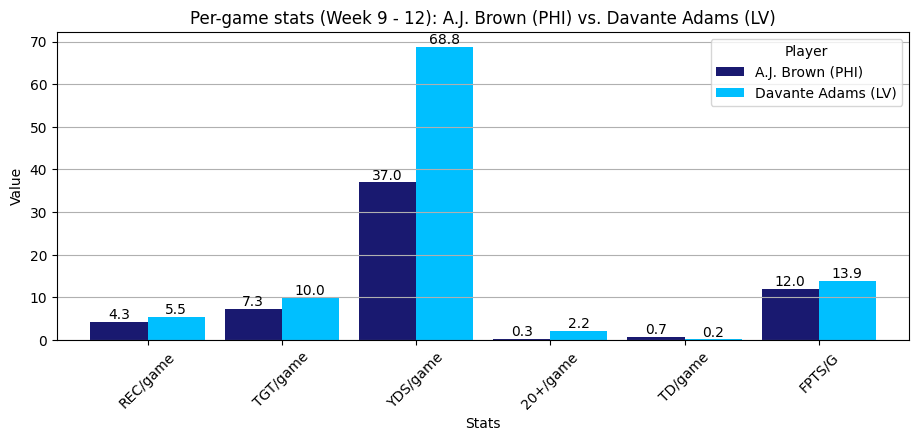

,Final Rank,G,FPTS,FPTS/G,Weeks,REC/game,TGT/game,YDS/game,20+/game,TD/game
Player,,,,,,,,,,
A.J. Brown (PHI),46,3,36.1,12.0,9 - 12,4.3,7.3,37.0,0.3,0.7
Davante Adams (LV),17,4,55.5,13.9,9 - 12,5.5,10.0,68.8,2.2,0.2


In [40]:
# Prompt the user to input the name of the players
player1 = input("Enter player 1 name")
player2 = input("Enter player 2 name")

# Extract and reorder rows for the two specified players
# Filter rows where the 'Player' column contains the names entered by the user
players = df[df['Player'].str.contains(player1) | df['Player'].str.contains(player2)]
players.set_index('Player', inplace=True)
player1_match = players.index[0] if player1 in players.index[0] else players.index[1]
player2_match = players.index[1] if player2 in players.index[1] else players.index[0]
players = players.reindex([player1_match, player2_match])

# Define columns to be compared
compare_columns = [col.replace('_weighted', '') for col in avg]

# Define a function to compare per-game stats of two players
def compare(player1, player2):

    # Plot the data
    chart = players[compare_columns].T.plot(kind='bar',
                                            color=['midnightblue', 'deepskyblue'],
                                            width=0.85,
                                            figsize=(11,4))

    # Format chart
    plt.title(f'Per-game stats (Week {weeks}): {player1} vs. {player2}')
    plt.xlabel('Stats')
    plt.ylabel('Value')
    plt.grid(axis='y')
    plt.xticks(rotation=45)

    # Add data labels above the bars
    for p in chart.patches:
        chart.annotate(f'{p.get_height():.1f}', 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha = 'center', va = 'center', 
                    xytext = (0, 5), 
                    textcoords = 'offset points')

    plt.show()

# Call the 'compare' function which creates and displays the visualization
compare(player1_match, player2_match)
players[['Final Rank'] + final_columns]